In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Load dataset
df = pd.read_csv("timeseries_version.csv")

df.head()

,Order_Date,Device_Type,Monthly_Demand,Lead_Time,Stock_Level,Supplier_Reliability,Seasonality_Factor
0,2018-01-01,Surgical,565,18,608,0.81,1.007333
1,2018-01-03,Therapeutic,480,12,497,0.91,0.975088
2,2018-01-05,Surgical,599,9,646,0.83,1.028933
3,2018-01-05,Monitoring,478,18,500,0.82,1.044259
4,2018-01-06,Monitoring,516,12,537,0.72,1.022368


In [3]:
df = df[['Order_Date' , 'Monthly_Demand']]

df.head()

,Order_Date,Monthly_Demand
0,2018-01-01,565
1,2018-01-03,480
2,2018-01-05,599
3,2018-01-05,478
4,2018-01-06,516


In [ ]:
# Ensure 'date' is a datetime type
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Set the date as the index
df.set_index('Order_Date', inplace=True)

# Resample by month and take the mean of daily demands for each month
monthly_df = df.resample('M').mean().reset_index()

# Rename column to reflect it's now monthly
monthly_df.rename(columns={'Monthly_Demand': 'monthly_avg_demand'}, inplace=True)

# View the result
monthly_df.head()

C:\Users\salma\AppData\Local\Temp\ipykernel_28100\2285738299.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean().reset_index()


,Order_Date,monthly_avg_demand
0,2018-01-31,515.235294
1,2018-02-28,533.481481
2,2018-03-31,553.076923
3,2018-04-30,589.171429
4,2018-05-31,606.523810


In [5]:
monthly_df.shape

(329, 2)

In [6]:
monthly_df.set_index('Order_Date', inplace=True)

monthly_df.head()

,monthly_avg_demand
Order_Date,
2018-01-31,515.235294
2018-02-28,533.481481
2018-03-31,553.076923
2018-04-30,589.171429
2018-05-31,606.523810


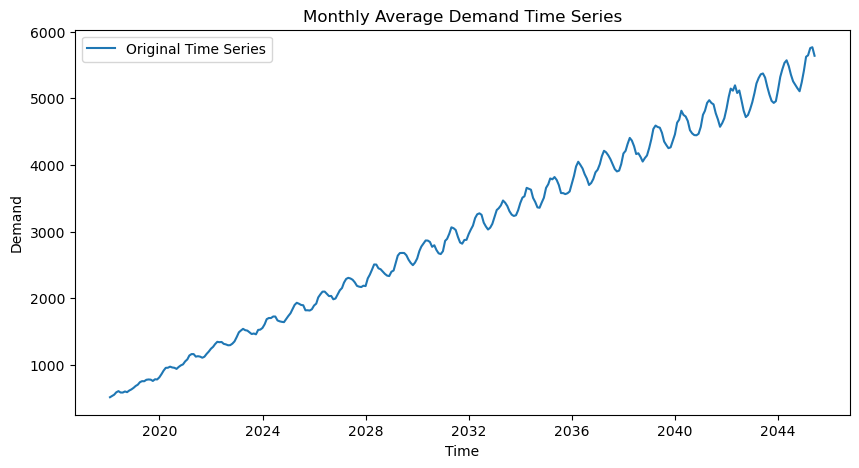

In [7]:
# Plot original time series
# Plot the original monthly demand over time to visually assess trend and seasonality.

plt.figure(figsize=(10,5))
plt.plot(monthly_df['monthly_avg_demand'], label="Original Time Series")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Monthly Average Demand Time Series")
plt.legend()
plt.show()

In [8]:
# Check for stationarity (ADF Test)
# Uses the Augmented Dickey-Fuller (ADF) test to check for stationarity.
# Stationary data means its statistical properties do not change over time.
# If p-value > 0.05, the data is not stationary, and differencing is needed.


def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

In [9]:
# Check stationarity of original data
adf_test(monthly_df['monthly_avg_demand'])

ADF Statistic: 0.2136353923668874
p-value: 0.9730160753743146
The series is NOT stationary.


In [10]:
# Seasonal differencing
# If the dataset has strong seasonality, applying seasonal differencing (Xt - Xt-12) removes repeating patterns.
# If after differencing, p-value < 0.05, the series is now stationary.


monthly_df['Seasonal_Diff'] = monthly_df['monthly_avg_demand'].diff(12)

adf_test(monthly_df['Seasonal_Diff'].dropna())

ADF Statistic: -5.479581321989165
p-value: 2.300384485235412e-06
The series is stationary.


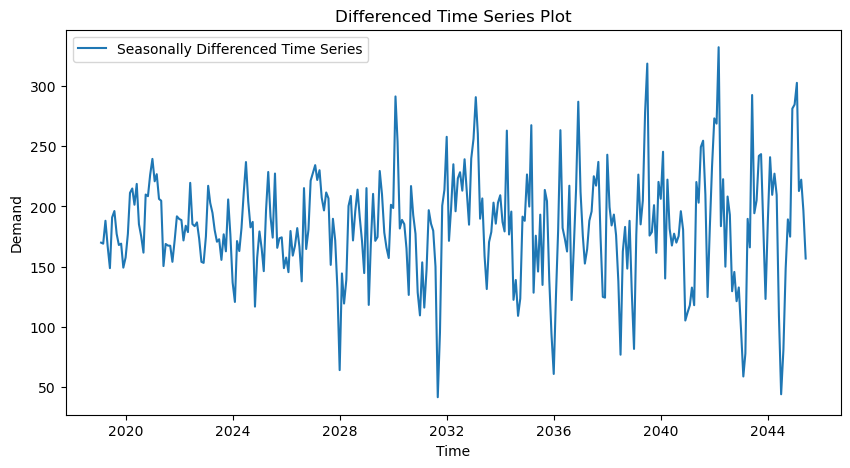

In [11]:
# Plot transformed data
# To visually confirm that trend and seasonality are removed.


plt.figure(figsize=(10,5))
plt.plot(monthly_df['Seasonal_Diff'], label="Seasonally Differenced Time Series")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Differenced Time Series Plot")
plt.legend()
plt.show()

differenced time series still shows an increasing variance over time, meaning the data might not be fully stationary. 
The increasing variance (heteroskedasticity) in this seasonally differenced time series is a common issue, especially when the original series has multiplicative seasonality or a trend that affects the variance over time. 
one strategy to deal with this problem is log transformation

In [12]:
# log transformation

monthly_df['Log_Demand'] = np.log(monthly_df['monthly_avg_demand'])



In [13]:
monthly_df.head()

,monthly_avg_demand,Seasonal_Diff,Log_Demand
Order_Date,,,
2018-01-31,515.235294,NaN,6.244624
2018-02-28,533.481481,NaN,6.279424
2018-03-31,553.076923,NaN,6.315497
2018-04-30,589.171429,NaN,6.378717
2018-05-31,606.523810,NaN,6.407744


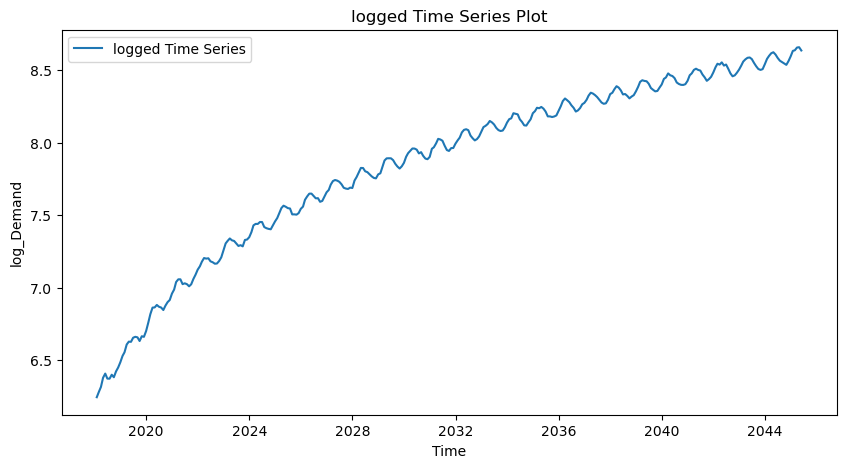

In [14]:
plt.figure(figsize=(10,5))
plt.plot(monthly_df['Log_Demand'], label="logged Time Series")
plt.xlabel("Time")
plt.ylabel("log_Demand")
plt.title("logged Time Series Plot")
plt.legend()
plt.show()

In [15]:
# perform seasonal differencing on the log-transformed series

monthly_df['Log_Seasonal_Diff'] = monthly_df['Log_Demand'].diff(12)
monthly_df = monthly_df.dropna(subset=['Log_Seasonal_Diff'])


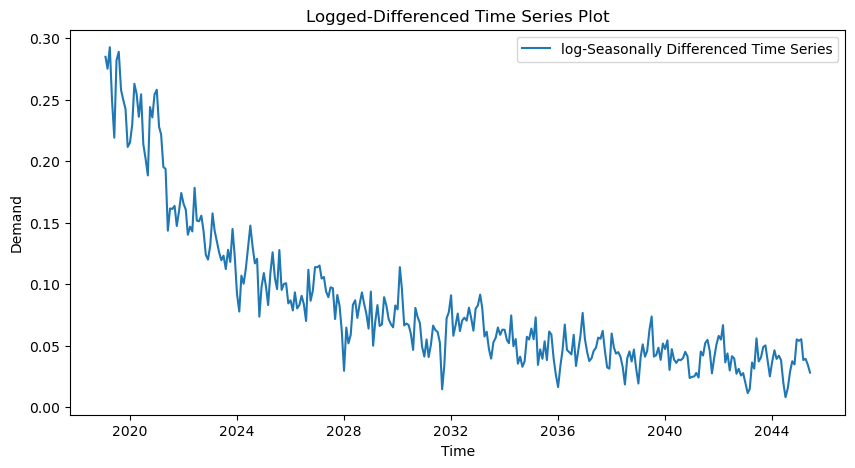

In [16]:
plt.figure(figsize=(10,5))
plt.plot(monthly_df['Log_Seasonal_Diff'], label="log-Seasonally Differenced Time Series")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Logged-Differenced Time Series Plot")
plt.legend()
plt.show()

In [17]:
# final ADF test
adf_test(monthly_df['Log_Seasonal_Diff'])

ADF Statistic: -4.560928748272441
p-value: 0.00015237056414139178
The series is stationary.


In [18]:
print("Number of NaNs:", monthly_df['Log_Seasonal_Diff'].isna().sum())
print("Unique values:", monthly_df['Log_Seasonal_Diff'].nunique())

Number of NaNs: 0
Unique values: 317


In [19]:
monthly_df.head()

,monthly_avg_demand,Seasonal_Diff,Log_Demand,Log_Seasonal_Diff
Order_Date,,,,
2019-01-31,685.096774,169.861480,6.529560,0.284936
2019-02-28,702.526316,169.044834,6.554683,0.275259
2019-03-31,741.166667,188.089744,6.608226,0.292728
2019-04-30,756.100000,166.928571,6.628174,0.249456
2019-05-31,755.166667,148.642857,6.626938,0.219194


In [20]:
monthly_df.dtypes

monthly_avg_demand    float64
Seasonal_Diff         float64
Log_Demand            float64
Log_Seasonal_Diff     float64
dtype: object

In [21]:
# auto_arima can be slow and memory-intensive when handling high-precision float64 time series.
# Reducing the precision of my time series data to lower memory usage and speed up computations:-

monthly_df['Log_Seasonal_Diff'] = monthly_df['Log_Seasonal_Diff'].astype('float32')

monthly_df['Log_Demand'] = monthly_df['Log_Demand'].astype('float32')



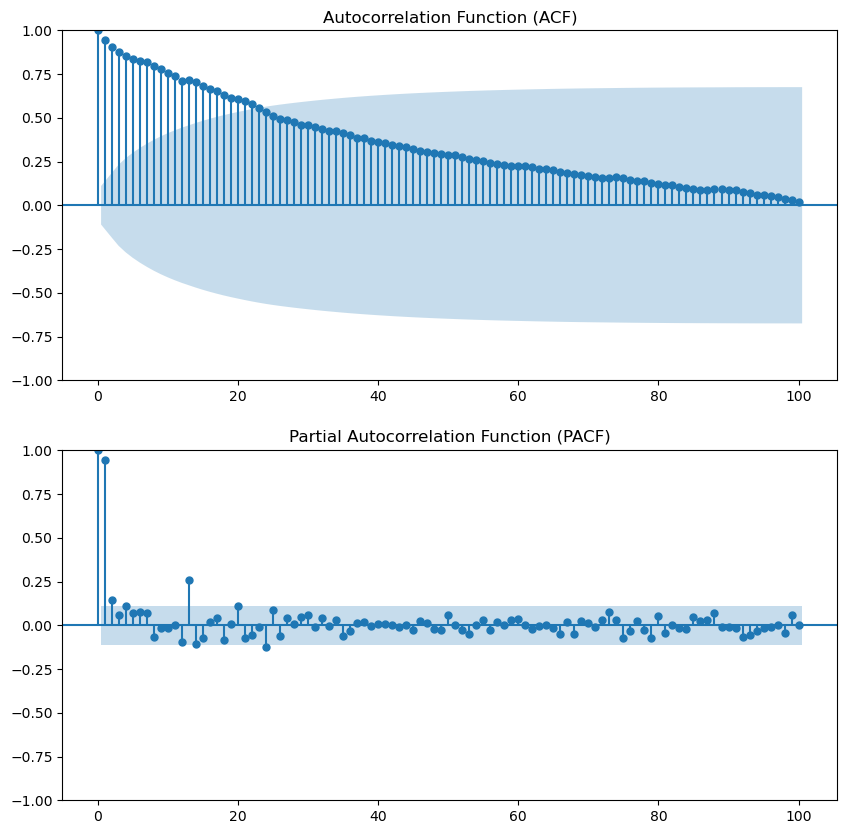

In [22]:
# ACF & PACF Plots
# These plots help confirm if differencing was effective and help in selecting the appropriate parameters for an ARIMA/SARIMA model.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# ACF plot
plot_acf(monthly_df['Log_Seasonal_Diff'], lags=100, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(monthly_df['Log_Seasonal_Diff'], lags=100, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

ACF (Top):Still shows slow decay, but much less than a non-stationary series. there are no strong spikes at specific seasonal lags (like 12, 24, etc. in monthly data), that suggests seasonality was removed successfully.

PACF (Bottom):A strong spike at lag 1 and quick drop-off after that is a classic sign of AR(1) in a stationary series.

Since the series is already differenced: my model should be based on the stationary version.

As I used seasonal differencing once, my model becomes a SARIMA(p, d=0, q)(P, D=1, Q, s).

In [23]:
# auto-arima model

# Fit Auto ARIMA without seasonal components (since differencing is applied)
model = auto_arima(monthly_df['Log_Seasonal_Diff'],
                   seasonal=False,  # No need for seasonal components
                   d=0,  # No regular differencing needed
                   max_p=5, max_q=5,  # Optimize AR and MA orders
                   n_jobs=-1,  # Parallel computation
                   maxiter=20,  # Limit iterations for efficiency
                   information_criterion='aic',  # Optimize based on AIC
                   stepwise=False,  # Perform a full search
                   suppress_warnings=True)

# Output the selected parameters
order_params = model.order  # (p, d, q)
seasonal_params = model.seasonal_order  # (P, D, Q, m)

print(f"Selected ARIMA Order: p={order_params[0]}, d={order_params[1]}, q={order_params[2]}")
print(f"Selected Seasonal Order: P={seasonal_params[0]}, D={seasonal_params[1]}, Q={seasonal_params[2]}, m={seasonal_params[3]}")
print("\nModel Summary:")
print(model.summary())

Selected ARIMA Order: p=2, d=0, q=1
Selected Seasonal Order: P=0, D=0, Q=0, m=0

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  317
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 861.022
Date:                Wed, 09 Apr 2025   AIC                          -1714.043
Time:                        00:02:42   BIC                          -1699.008
Sample:                    01-31-2019   HQIC                         -1708.038
                         - 05-31-2045                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2298      0.156      7.869      0.000       0.924       1.536
ar.L2         -0.2372      0.154   

order: This gives the best non-seasonal ARIMA parameters (p, d, q):

p: Number of autoregressive terms.

d: Degree of differencing.

q: Number of moving average terms.

seasonal_order: This gives the best seasonal ARIMA parameters (P, D, Q, s):

P: Number of seasonal autoregressive terms.

D: Degree of seasonal differencing.

Q: Number of seasonal moving average terms.

m: Seasonal period (12 in this case).

In [23]:
p = 2
d = 0
q = 1
P = 0
D = 0
Q = 0
s = 0

In [24]:
# Train-test split
# Splitting data into 80% train, 20% test helps evaluate model performance.

train_size = int(len(monthly_df['Log_Seasonal_Diff']) * 0.8)

train = monthly_df['Log_Seasonal_Diff'].iloc[:train_size]
test = monthly_df['Log_Seasonal_Diff'].iloc[train_size:]



In [25]:
# Fit SARIMA model with best parameters
# Builds a SARIMA(X) model using the best parameters found by auto_arima.
# Fits the model on the training data.

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, 
                order=(2, 0, 1), 
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False, 
                enforce_invertibility=False)
sarima_model = model.fit()

# Forecast for test period
preds = sarima_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)


# Reverse seasonal differencing using the original logged data
# Get the starting point from the original log-transformed series
seasonal_lag = 12

last_train_index = train.index[-1]
start_loc = monthly_df['Log_Demand'].index.get_loc(last_train_index) + 1

restored_preds = preds.copy()

for i in range(len(preds)):
    restored_preds.iloc[i] += monthly_df['Log_Demand'].iloc[start_loc + i - seasonal_lag]


# Reverse log transformation (exponential)
preds_final = np.exp(restored_preds)  # Convert back from log scale
test_actual = np.exp(monthly_df['Log_Demand'].iloc[start_loc:start_loc + len(preds_final)])  # Convert actual values


c:\Users\salma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\salma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [ ]:
# my first attempt to train sarima model resulted in an error related to the unequal length of these two data frames. As one of them was computed before differencing
# and the other one after differencing. So, I added this test step to assess my tries to solve this problem. 
# finally it worked as shown:-

print(f"Length of preds_final: {len(preds_final)}")
print(f"Length of test_actual: {len(test_actual)}")

Length of preds_final: 64
Length of test_actual: 64


In [27]:
# Evaluation Metrics

mae = mean_absolute_error(test_actual, preds_final)
mse = mean_squared_error(test_actual, preds_final)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 64.2311
MSE: 6321.7582
RMSE: 79.5095


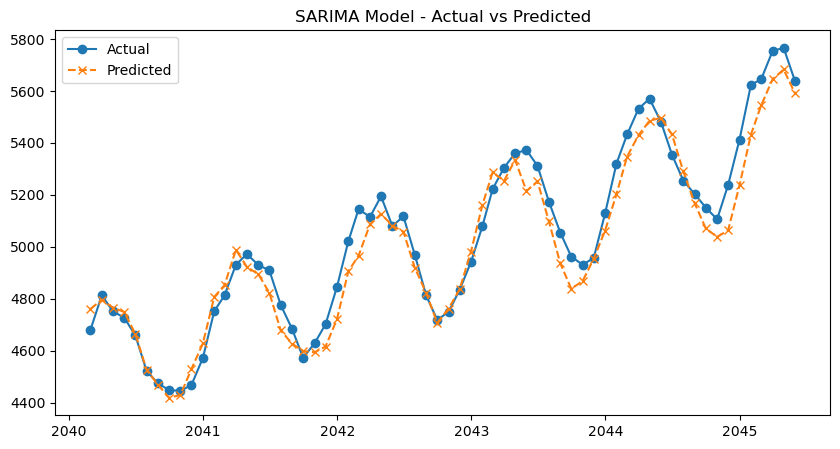

In [28]:
# Plot Actual vs Predicted

plt.figure(figsize=(10, 5))
plt.plot(test_actual.index, test_actual, label='Actual', marker='o')
plt.plot(test_actual.index, preds_final, label='Predicted', linestyle='--', marker='x')
plt.title('SARIMA Model - Actual vs Predicted')
plt.legend()
plt.show()

In [29]:
import joblib

# Save the fitted model

joblib.dump(sarima_model, 'sarima_model.pkl')



['sarima_model.pkl']

In [ ]:
# Save last 12 values *before* differencing, used during forcasting to reverse differencing for prediction values:-

last_values = monthly_df["Log_Demand"].dropna()[-12:]


joblib.dump(last_values, "last_values.pkl")

['last_values.pkl']

In [ ]:
# this is just a quick test to ensure that I saved the right series

last_series = joblib.load("last_values.pkl")

print("Last series:", last_series)
print("Length:", len(last_series))
print("Index type:", type(last_series.index))

Last series: Order_Date
2044-06-30    8.585854
2044-07-31    8.566866
2044-08-31    8.557020
2044-09-30    8.546985
2044-10-31    8.538124
2044-11-30    8.563787
2044-12-31    8.596592
2045-01-31    8.634682
2045-02-28    8.638590
2045-03-31    8.657651
2045-04-30    8.659806
2045-05-31    8.637318
Name: Log_Demand, dtype: float32
Length: 12
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
